# CodonVE on mRFP Expression

This notebook walks through an end‑to‑end CodonVE (Codon to Vector Embeddings) pipeline on the mRFP dataset:

1. Load and clean the mRFP expression data  
2. Convert sequences into codon tokens  
3. Train a **CodonVE (Word2Vec)** embedding model  
4. Build sequence‑level embeddings  
5. Train regression models to predict expression (Linear Regreesion, XGBoost, Random Forest)  
6. Visualize the result




In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Install dependencies

In this step we install all Python packages needed for working with CodonVE on the mRFP dataset.  


In [2]:
!pip install gensim pandas numpy scikit-learn xgboost umap-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 98.1 MB/s eta 0:00:00


### Imports and global settings

Here we import all required Python libraries (data handling, machine learning, visualization) and set random seeds for reproducibility.

In [3]:
import os
import random
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import umap

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

### Loading the mRFP dataset

We load the mRFP expression dataset from a CSV file, check that the expected columns are present (`sequence` and `expression`), and quickly inspect the first few rows.

In [4]:
DATA_PATH = '/content/gdrive/MyDrive/Bioinformatics/Projects/Codon-Benchmark/mRFP_Expression.csv'  # change if your file is named differently
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH}. Please place the standard mRFP CSV here or update DATA_PATH.")

df = pd.read_csv(DATA_PATH)
print('Rows:', len(df))
print(df.head())

# Basic sanity: ensure columns exist
assert 'Sequence' in df.columns, "Dataset must contain a 'Sequence' column"
assert 'Value' in df.columns, "Dataset must contain an 'Value' column"

Rows: 1459
                                            Sequence      Value  \
0  AUGGCAUCAUCAGAAGACGUCAUAAAAGAAUUUAUGCGAUUCAAAG...  10.164760   
1  AUGGCGUCUUCAGAGGAUGUAAUCAAGGAAUUCAUGCGUUUUAAGG...  10.572869   
2  AUGGCAUCAUCGGAAGAUGUAAUAAAGGAAUUUAUGCGUUUCAAAG...   9.766912   
3  AUGGCGAGUAGUGAAGACGUUAUCAAAGAAUUUAUGCGUUUUAAGG...   9.926981   
4  AUGGCUUCUUCUGAGGACGUAAUAAAGGAGUUCAUGAGGUUCAAGG...   9.857074   

           Dataset  Split  
0  mRFP Expression  train  
1  mRFP Expression  train  
2  mRFP Expression  train  
3  mRFP Expression  train  
4  mRFP Expression  train  


### Preprocess sequences into codons

Each nucleotide sequence string is converted into a list of codons (3‑mer tokens).  
We also clean the sequence (keep only A/T/G/C/U, convert U→T, trim to full codons) and attach the resulting codon lists to the dataframe.

In [5]:
# Ensure sequences length divisible by 3 (or trim trailing bases)

def seq_to_codons(seq):
    seq = seq.strip().upper()
    # optionally remove non-ATGC characters
    seq = ''.join([c for c in seq if c in 'ATGCU'])
    # replace U with T if present
    seq = seq.replace('U', 'T')
    L = len(seq) - (len(seq) % 3)
    seq = seq[:L]
    return [seq[i:i+3] for i in range(0, len(seq), 3)]

# Apply
df['codons'] = df['Sequence'].apply(seq_to_codons)
# Quick check: any empty codons?
empty_count = (df['codons'].map(len) == 0).sum()
print('Empty codons rows:', empty_count)

sentences = df['codons'].tolist()

Empty codons rows: 0


### Train CodonVE (Word2Vec) on codon sequences

We treat each CDS as a 'sentence' and each codon as a 'word', then train a Word2Vec model to learn a dense embedding vector for each codon.  
This is the core CodonVE representation that we will use in downstream models.

In [6]:
# Hyperparameters you can tune
EMBED_SIZE = 100
WINDOW = 5
MIN_COUNT = 1
SG = 1  # skip-gram
NEGATIVE = 10
WORKERS = 4
EPOCHS = 10

w2v = Word2Vec(
    sentences=sentences,
    vector_size=EMBED_SIZE,
    window=WINDOW,
    min_count=MIN_COUNT,
    sg=SG,
    negative=NEGATIVE,
    workers=WORKERS,
    seed=RANDOM_SEED
)

# Further training (to set epochs)
w2v.train(sentences, total_examples=len(sentences), epochs=EPOCHS)

# Save model
w2v.save('codon2vec.model')
print('Vocabulary size (codons):', len(w2v.wv.index_to_key))
print('Sample codons:', w2v.wv.index_to_key[:20])

Vocabulary size (codons): 60
Sample codons: ['AAG', 'GAA', 'GAG', 'ATG', 'GAC', 'AAA', 'GGT', 'TAC', 'TTC', 'GGG', 'CTG', 'GAT', 'GGA', 'TAT', 'ACG', 'CAA', 'GGC', 'CCG', 'TTT', 'ATA']


### Inspect codon embeddings

We look up a few example codons in the trained embedding space and print their vectors or nearest neighbours.  
This helps verify that training worked and gives intuition about codon similarity.

In [7]:
for codon in sorted(w2v.wv.index_to_key):
    print(codon, w2v.wv[codon][:6])  # print first 6 dims

AAA [-6.7965642e-02  4.4128608e-02  1.1937337e-01 -3.1756490e-01
 -2.8320813e-01  7.3413816e-05]
AAC [ 0.12980399  0.04829379  0.4752719   0.18705763 -0.416185   -0.13886471]
AAG [-0.06704502 -0.03551742  0.08903226 -0.15344508 -0.11997827  0.26204586]
AAT [ 0.17178527  0.01979111  0.42733043  0.40388176 -0.267886    0.0377318 ]
ACA [ 4.9178845e-01  6.0361288e-02 -4.2953409e-04  1.1045303e-02
 -2.2325297e-01  2.1191280e-01]
ACC [-0.07444847 -0.00905313  0.15646034 -0.29158676 -0.23066613  0.29163522]
ACG [ 0.31749254 -0.04878866  0.20857206 -0.28658107 -0.26323235 -0.14829463]
ACT [ 0.4271031  -0.06852365 -0.11641624  0.01576635 -0.01880619  0.07125714]
AGA [ 0.32055435  0.2935607  -0.17027293  0.09586294 -0.34962758  0.53144014]
AGC [ 8.740633e-01 -3.904852e-01  9.103718e-02 -3.806498e-01 -4.361122e-04
 -9.611754e-02]
AGG [ 0.37063023  0.22981012 -0.24429923  0.09438153 -0.3462704   0.5154084 ]
AGT [ 0.8299923  -0.3741781   0.12260125 -0.35446793 -0.03865698 -0.00892963]
ATA [ 0.21463

### Build sequence-level embeddings

We aggregate codon embeddings into a single fixed-length vector for each sequence by taking the mean of its codon vectors.  
These sequence-level embeddings will be used as input features for regression models predicting expression.

In [8]:
import numpy as np

def seq_embedding_mean(codons):
    vecs = []
    for c in codons:
        if c in w2v.wv:
            vecs.append(w2v.wv[c])
    if len(vecs) == 0:
        return np.zeros(EMBED_SIZE)
    return np.mean(vecs, axis=0)

# compute and add to dataframe
embeddings = np.vstack(df['codons'].apply(seq_embedding_mean).values)
df_emb = df.copy()
df_emb['embedding'] = list(embeddings)

### Train/test split and feature scaling

We split the dataset into training and test sets, then (optionally) standardize / scale the features.  
This prepares the data for training regression models and evaluating generalization performance.

In [9]:
X = np.vstack(df_emb['embedding'].values)
y = df_emb['Value'].values.astype(float)

X_train = X[df_emb['Split'] == 'train']
y_train = y[df_emb['Split'] == 'train']

X_test = X[df_emb['Split'] == 'test']
y_test = y[df_emb['Split'] == 'test']

### Baseline model: Linear regression

We fit a simple linear regression model on top of the sequence embeddings to predict expression levels.  
This acts as a baseline to compare more complex models against, and we compute common regression metrics (R², RMSE, MAE).

In [10]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

print('Linear regression — R2:', r2_score(y_test, y_pred_lr))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print('MAE:', mean_absolute_error(y_test, y_pred_lr))

Linear regression — R2: 0.21681164846539358
RMSE: 0.6600628344869105
MAE: 0.48658930779117054


### XGBoost regression model

We fit a gradient-boosted tree model (XGBoost) on the same features.  
This non-linear model often captures more complex relationships between codon usage patterns and expression, and we evaluate it with the same metrics as the baseline.

In [11]:
xgb = XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    random_state=RANDOM_SEED,
    n_jobs=-1
)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

print('XGBoost — R2:', r2_score(y_test, y_pred_xgb))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print('MAE:', mean_absolute_error(y_test, y_pred_xgb))

XGBoost — R2: 0.16147224236548297
RMSE: 0.6829845697740867
MAE: 0.49654210282497696


### Random forest model
We use zero shot sequence embeddings of the model and train the random forest model to predict the mRFP expression. Then we calculate the metrics for the training, validation, and test sets so we can plot them in the following step.

In [12]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, StratifiedKFold # GridSearchCV is used to find the best hyperparameters
from scipy.stats import spearmanr
from sklearn.metrics import r2_score

if 'X' in locals() and 'y' in locals() and 'df_emb' in locals():
    print("=== TRAINING RANDOM FOREST ===")

    # Split data based on the dataset splits in df_emb
    train_mask = df_emb['Split'] == 'train'
    val_mask = df_emb['Split'] == 'val'
    test_mask = df_emb['Split'] == 'test'

    X_train_rf = X[train_mask]
    X_val_rf = X[val_mask]
    X_test_rf = X[test_mask]
    y_train_rf = y[train_mask]
    y_val_rf = y[val_mask]
    y_test_rf = y[test_mask]

    print(f"Train: {X_train_rf.shape[0]}, Val: {X_val_rf.shape[0]}, Test: {X_test_rf.shape[0]}")

    # Combine train and validation for GridSearchCV
    X_train_val = np.vstack([X_train_rf, X_val_rf])
    y_train_val = np.concatenate([y_train_rf, y_val_rf])

    # Create validation indices for GridSearchCV
    # Train indices: 0 to len(X_train_rf)-1
    # Val indices: len(X_train_rf) to len(X_train_val)-1
    train_indices = list(range(len(X_train_rf)))
    val_indices = list(range(len(X_train_rf), len(X_train_val)))
    cv_splits = [(train_indices, val_indices)]

    # Define hyperparameter grid
    param_grid = {
        'n_estimators': [1000],
        'max_depth': [10],
        'min_samples_split': [25],
        'min_samples_leaf': [2],
    }

    # Create base model
    rf_base = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1)

    # Grid search with validation split
    print("Performing hyperparameter tuning...")
    grid_search = GridSearchCV(
        estimator=rf_base,
        param_grid=param_grid,
        cv=cv_splits,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )

    # Fit grid search
    grid_search.fit(X_train_val, y_train_val)

    # Get best model
    rf = grid_search.best_estimator_

    print(f"\n=== BEST PARAMETERS ===")
    for param, value in grid_search.best_params_.items():
        print(f"{param}: {value}")
    print(f"Best validation R²: {grid_search.best_score_:.4f}")

    # Train final model on the actual training set
    rf.fit(X_train_rf, y_train_rf)

    # Predictions on all splits
    y_pred_train = rf.predict(X_train_rf)
    y_pred_val = rf.predict(X_val_rf)
    y_pred_test = rf.predict(X_test_rf)

    # Calculate metrics for all splits
    train_r2 = r2_score(y_train_rf, y_pred_train)
    val_r2 = r2_score(y_val_rf, y_pred_val)
    test_r2 = r2_score(y_test_rf, y_pred_test)

    train_spearmanr, _ = spearmanr(y_train_rf, y_pred_train)
    val_spearmanr, _ = spearmanr(y_val_rf, y_pred_val)
    test_spearmanr, _ = spearmanr(y_test_rf, y_pred_test)

    print(f"\n=== FINAL RESULTS ===")
    print(f"Train R²: {train_r2:.4f} | Spearman r: {train_spearmanr:.4f}")
    print(f"Val R²:   {val_r2:.4f} | Spearman r: {val_spearmanr:.4f}")
    print(f"Test R²:  {test_r2:.4f} | Spearman r: {test_spearmanr:.4f}")

else:
    print("❌ Cannot train - missing data")


=== TRAINING RANDOM FOREST ===
Train: 1021, Val: 219, Test: 219
Performing hyperparameter tuning...
Fitting 1 folds for each of 1 candidates, totalling 1 fits

=== BEST PARAMETERS ===
max_depth: 10
min_samples_leaf: 2
min_samples_split: 25
n_estimators: 1000
Best validation R²: 0.1699

=== FINAL RESULTS ===
Train R²: 0.5785 | Spearman r: 0.8265
Val R²:   0.1699 | Spearman r: 0.4345
Test R²:  0.1928 | Spearman r: 0.5455


Random forest achieved the best performance among all models, with the highest Test R² (0.1782) and Test Spearman correlation (0.5192). This suggests its effectiveness in capturing non-linear relationships.

### Save artifacts

Finally, we save the trained Codon2Vec model, the processed dataframe (with codon lists and embeddings), and any other useful artifacts to disk so they can be reused in other notebooks or scripts.

In [14]:
np.save('sequence_embeddings.npy', embeddings)
df.to_csv('mRFP_with_codons.csv', index=False)
w2v.wv.save_word2vec_format('codon_vectors.txt')

print('Saved model and embeddings.')

Saved model and embeddings.


### Plot Results

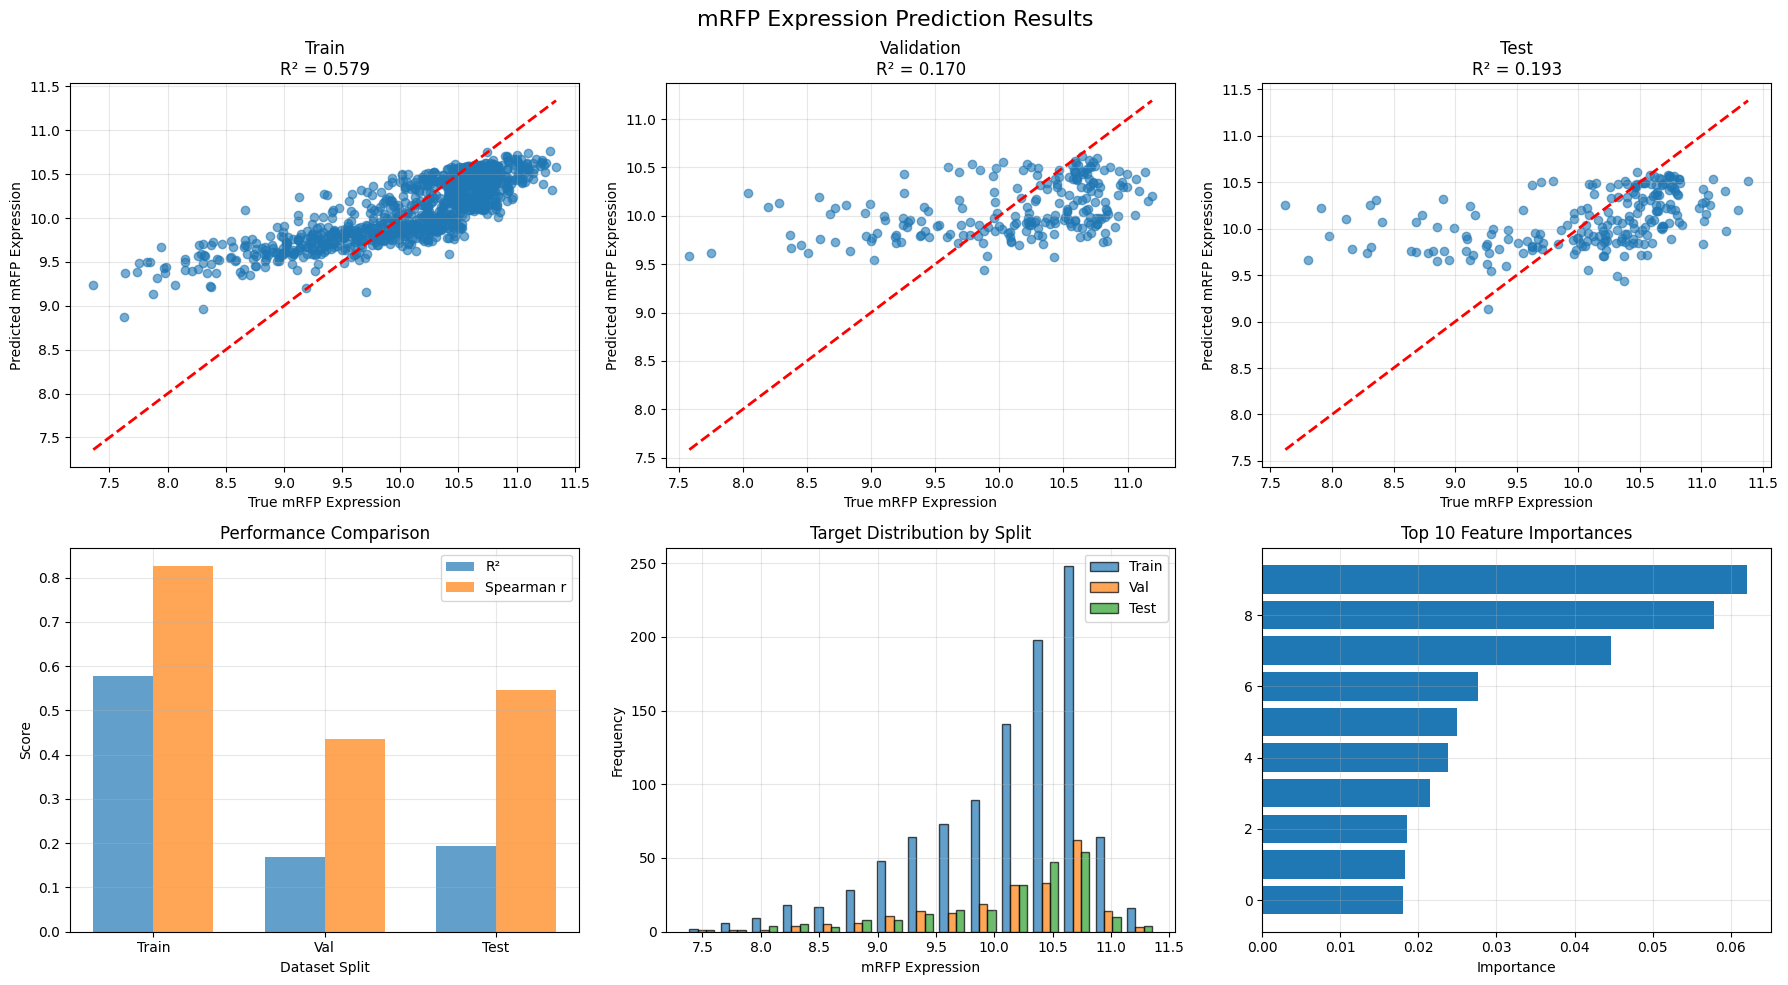

In [15]:
if 'y_test' in locals():
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('mRFP Expression Prediction Results', fontsize=16)

    # Predicted vs True for all splits
    splits = [('Train', y_train_rf, y_pred_train, train_r2),
              ('Validation', y_val_rf, y_pred_val, val_r2),
              ('Test', y_test_rf, y_pred_test, test_r2)]

    for i, (split_name, y_true, y_pred, r2) in enumerate(splits):
        axes[0, i].scatter(y_true, y_pred, alpha=0.6)
        min_val = min(y_true.min(), y_pred.min())
        max_val = max(y_true.max(), y_pred.max())
        axes[0, i].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
        axes[0, i].set_xlabel('True mRFP Expression')
        axes[0, i].set_ylabel('Predicted mRFP Expression')
        axes[0, i].set_title(f'{split_name}\nR² = {r2:.3f}')
        axes[0, i].grid(True, alpha=0.3)

    # Performance comparison
    r2_scores = [train_r2, val_r2, test_r2]
    spearmanr_scores = [train_spearmanr, val_spearmanr, test_spearmanr]

    x_pos = np.arange(len(splits))
    width = 0.35

    axes[1, 0].bar(x_pos - width/2, r2_scores, width, label='R²', alpha=0.7)
    axes[1, 0].bar(x_pos + width/2, spearmanr_scores, width, label='Spearman r', alpha=0.7)
    axes[1, 0].set_xlabel('Dataset Split')
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].set_title('Performance Comparison')
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels(['Train', 'Val', 'Test'])
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Target distribution across splits
    axes[1, 1].hist([y_train_rf, y_val_rf, y_test_rf], bins=15, alpha=0.7,
                   label=['Train', 'Val', 'Test'], edgecolor='black')
    axes[1, 1].set_xlabel('mRFP Expression')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Target Distribution by Split')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # Feature importance
    top_features = np.argsort(rf.feature_importances_)[-10:]
    axes[1, 2].barh(range(10), rf.feature_importances_[top_features])
    axes[1, 2].set_xlabel('Importance')
    axes[1, 2].set_title('Top 10 Feature Importances')
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

else:
    print("❌ No results to plot")